## Hybrid method: Recursive feature elimination

This method consists of the following steps:

1) Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance, or LASSO / Ridge, or the linear / logistic regression coefficients.

2) Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.

3) Calculate a performance metric of your choice: roc-auc, mse, rmse, accuracy.

4) If the metric decreases by more of an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

5) Repeat steps 2-4 until all features have been removed (and therefore evaluated) and the drop in performance assessed.


I call this a hybrid method because:

- it combines the importance derived from the machine learning algorithm like embedded methods,
- and it removes as well one feature at a time, and calculates a new metric based on the new subset of features and the machine learning algorithm of choice, like wrapper methods.

The difference between this method and the step backwards feature selection we learned in previous lectures lies in that it does not remove all features first in order to determine which one to remove. It removes the least important one, based on the machine learning model derived important. And then, it makes an assessment as to whether that feature should be removed or not. So it removes each feature only once during selection, whereas step backward feature selection removes all the features at each step of selection.

This method is therefore faster than wrapper methods and generally better than embedded methods. In practice it works extremely well. It does also account for correlations (depending on how stringent you set the arbitrary performance drop threshold). On the downside, the drop in performance assessed to decide whether the feature should be kept or removed, is set arbitrarily. The smaller the drop the more features will be selected, and vice versa.


**Note** For the demonstration, lets use XGBoost, but this method is useful for any machine learning algorithm. In fact, the importance of the features are determined specifically for the algorithm used. Therefore, different algorithms may return different subsets of important features.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn.metrics import roc_auc_score, r2_score

In [2]:
# load dataset
data = pd.read_csv('D:/Machine Learning_Class/Feature Selection/Data/bnp-paribas-cardif-claims-management/paribas.csv', nrows=50000)
data.shape

(50000, 133)

In [3]:
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [4]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(50000, 114)

### Important

In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [6]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target', 'ID'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 112), (15000, 112))

In [7]:
# the first step of this procedure  consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict_proba(X_test)[:, 1]
auc_score_all = roc_auc_score(y_test, y_pred_test)
print('Test all features xgb ROC AUC=%f' % (auc_score_all))

Test all features xgb ROC AUC=0.713140


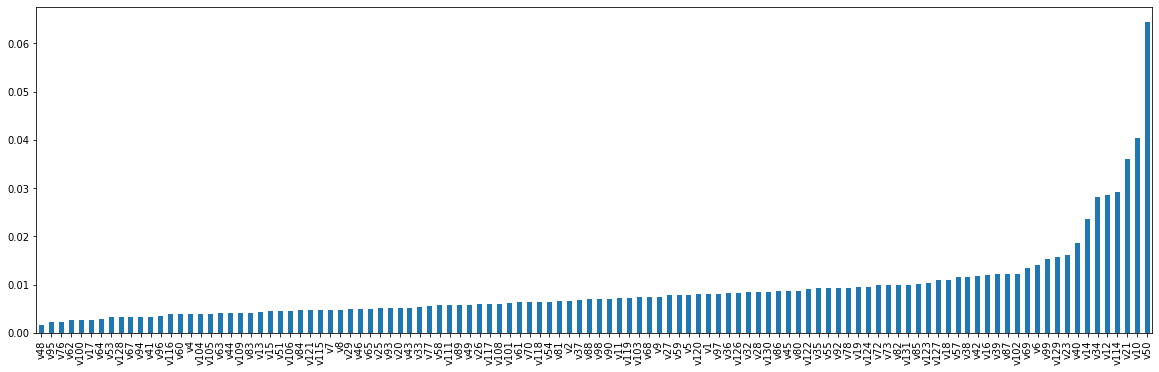

In [8]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the least to the most
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(20,6))

In [8]:
# view the list of ordered features
features = list(features.index)
features

['v48',
 'v95',
 'v76',
 'v62',
 'v100',
 'v17',
 'v64',
 'v53',
 'v128',
 'v67',
 'v94',
 'v41',
 'v96',
 'v116',
 'v60',
 'v4',
 'v104',
 'v105',
 'v63',
 'v44',
 'v109',
 'v83',
 'v13',
 'v15',
 'v51',
 'v106',
 'v84',
 'v121',
 'v115',
 'v7',
 'v8',
 'v29',
 'v46',
 'v65',
 'v25',
 'v93',
 'v20',
 'v43',
 'v33',
 'v77',
 'v58',
 'v111',
 'v89',
 'v49',
 'v26',
 'v117',
 'v108',
 'v101',
 'v61',
 'v70',
 'v118',
 'v54',
 'v81',
 'v2',
 'v37',
 'v88',
 'v98',
 'v90',
 'v11',
 'v119',
 'v103',
 'v68',
 'v9',
 'v27',
 'v59',
 'v5',
 'v120',
 'v1',
 'v97',
 'v36',
 'v126',
 'v32',
 'v28',
 'v130',
 'v86',
 'v45',
 'v80',
 'v122',
 'v35',
 'v55',
 'v92',
 'v78',
 'v19',
 'v124',
 'v72',
 'v73',
 'v82',
 'v131',
 'v85',
 'v123',
 'v127',
 'v18',
 'v57',
 'v38',
 'v42',
 'v16',
 'v39',
 'v87',
 'v102',
 'v69',
 'v6',
 'v99',
 'v129',
 'v23',
 'v40',
 'v14',
 'v34',
 'v12',
 'v114',
 'v21',
 'v10',
 'v50']

In [9]:
# the final step consists in removing one at a time
# all the features, from the least to the most
# important, and build an xgboost at each round.

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is smaller than the original one
# (with all the features), then that feature that was removed
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature elimination:

# first we arbitrarily set the drop in roc-auc
# if the drop is below this threshold,
# the feature will be removed
tol = 0.0005

print('doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = xgb.XGBClassifier(
        nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

    # fit model with all variables minus the removed features
    # and the feature to be evaluated
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test.drop(features_to_remove + [feature], axis=1))[:, 1]

    # calculate the new roc-auc
    auc_score_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((auc_score_int)))

    # print the original roc-auc with all the features
    print('All features Test ROC AUC={}'.format((auc_score_all)))

    # determine the drop in the roc-auc
    diff_auc = auc_score_all - auc_score_int

    # compare the drop in roc-auc with the tolerance
    # we set previously
    if diff_auc >= tol:
        print('Drop in ROC AUC={}'.format(diff_auc))
        print('keep: ', feature)
        print
    else:
        print('Drop in ROC AUC={}'.format(diff_auc))
        print('remove: ', feature)
        print
        # if the drop in the roc is small and we remove the
        # feature, we need to set the new roc to the one based on
        # the remaining features
        auc_score_all = auc_score_int
        
        # and append the feature to remove to the collecting
        # list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

doing recursive feature elimination

testing feature:  v48  which is feature  1  out of  112
New Test ROC AUC=0.7127500791811988
All features Test ROC AUC=0.7131402642043081
Drop in ROC AUC=0.0003901850231092796
remove:  v48

testing feature:  v95  which is feature  2  out of  112
New Test ROC AUC=0.7135813338128427
All features Test ROC AUC=0.7127500791811988
Drop in ROC AUC=-0.0008312546316439073
remove:  v95

testing feature:  v76  which is feature  3  out of  112
New Test ROC AUC=0.7138054503888731
All features Test ROC AUC=0.7135813338128427
Drop in ROC AUC=-0.00022411657603038648
remove:  v76

testing feature:  v62  which is feature  4  out of  112
New Test ROC AUC=0.7136766175725151
All features Test ROC AUC=0.7138054503888731
Drop in ROC AUC=0.00012883281635800437
remove:  v62

testing feature:  v100  which is feature  5  out of  112
New Test ROC AUC=0.7133000075260361
All features Test ROC AUC=0.7136766175725151
Drop in ROC AUC=0.0003766100464790423
remove:  v100

testing feat

New Test ROC AUC=0.7142214907489433
All features Test ROC AUC=0.7141664880507163
Drop in ROC AUC=-5.500269822700243e-05
remove:  v49

testing feature:  v26  which is feature  45  out of  112
New Test ROC AUC=0.7135912468747962
All features Test ROC AUC=0.7142214907489433
Drop in ROC AUC=0.0006302438741470073
keep:  v26

testing feature:  v117  which is feature  46  out of  112
New Test ROC AUC=0.7140071762677549
All features Test ROC AUC=0.7142214907489433
Drop in ROC AUC=0.00021431448118836016
remove:  v117

testing feature:  v108  which is feature  47  out of  112
New Test ROC AUC=0.7143510633460441
All features Test ROC AUC=0.7140071762677549
Drop in ROC AUC=-0.00034388707828925114
remove:  v108

testing feature:  v101  which is feature  48  out of  112
New Test ROC AUC=0.712959856340498
All features Test ROC AUC=0.7143510633460441
Drop in ROC AUC=0.00139120700554618
keep:  v101

testing feature:  v61  which is feature  49  out of  112
New Test ROC AUC=0.7140325260878748
All feature

New Test ROC AUC=0.7158320550744075
All features Test ROC AUC=0.7161673730257594
Drop in ROC AUC=0.0003353179513518878
remove:  v131

testing feature:  v85  which is feature  89  out of  112
New Test ROC AUC=0.7149654882419743
All features Test ROC AUC=0.7158320550744075
Drop in ROC AUC=0.0008665668324332465
keep:  v85

testing feature:  v123  which is feature  90  out of  112
New Test ROC AUC=0.7150391950633148
All features Test ROC AUC=0.7158320550744075
Drop in ROC AUC=0.0007928600110926887
keep:  v123

testing feature:  v127  which is feature  91  out of  112
New Test ROC AUC=0.7151325430633768
All features Test ROC AUC=0.7158320550744075
Drop in ROC AUC=0.0006995120110306896
keep:  v127

testing feature:  v18  which is feature  92  out of  112
New Test ROC AUC=0.7147288817010695
All features Test ROC AUC=0.7158320550744075
Drop in ROC AUC=0.0011031733733379845
keep:  v18

testing feature:  v57  which is feature  93  out of  112
New Test ROC AUC=0.7154464320325455
All features Test

In [10]:
# capture the 56 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_xgb = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# fit the model with the selected features
final_xgb.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = final_xgbl.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
auc_score_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (auc_score_final))
print('Test all features ROC AUC=%f' % (auc_score_all))

Test selected features ROC AUC=0.715491


As you can see, the xgb model built with 56 features shows a similar performance than the one built with the total features (0.715 vs 0.713).

We may not be able to get this right from the beginning though, as we did here. This method of feature selection does require that you try a few different tolerances / thresholds until you find the right number of features.

Why don't you go ahead and try different values? Try with lower and bigger thresholds and get a feeling of how much this affects the number of selected features.

### Regression

In [22]:
# load dataset
data = pd.read_csv('houseprice.csv', nrows=50000)
data.shape

(1460, 81)

In [23]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [28]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Id','SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 36), (438, 36))

In [29]:
# the first step of this procedure consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = xgb.XGBRegressor(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict(X_test)
r2_score_all = r2_score(y_test, y_pred_test)
print('Test all features xgb R2 = %f' % (r2_score_all))

Test all features xgb R2 = 0.818551


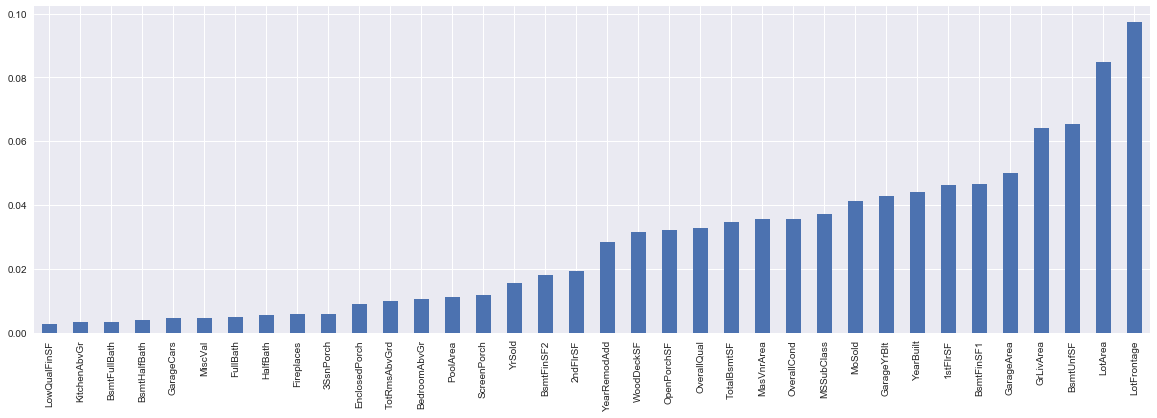

In [30]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the least to the most
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(20,6))

In [31]:
# view the list of ordered features
features = list(features.index)
features

['LowQualFinSF',
 'KitchenAbvGr',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageCars',
 'MiscVal',
 'FullBath',
 'HalfBath',
 'Fireplaces',
 '3SsnPorch',
 'EnclosedPorch',
 'TotRmsAbvGrd',
 'BedroomAbvGr',
 'PoolArea',
 'ScreenPorch',
 'YrSold',
 'BsmtFinSF2',
 '2ndFlrSF',
 'YearRemodAdd',
 'WoodDeckSF',
 'OpenPorchSF',
 'OverallQual',
 'TotalBsmtSF',
 'MasVnrArea',
 'OverallCond',
 'MSSubClass',
 'MoSold',
 'GarageYrBlt',
 'YearBuilt',
 '1stFlrSF',
 'BsmtFinSF1',
 'GarageArea',
 'GrLivArea',
 'BsmtUnfSF',
 'LotArea',
 'LotFrontage']

In [32]:
# the final step consists in removing one at a time
# all the features, from the least to the most
# important, and build an xgboost at each round.

# once we build the model, we calculate the new r2
# if the new r2 is smaller than the original one
# (with all the features), then that feature that was removed
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature elimination:

# first we arbitrarily set the drop in r2
# if the drop is below this threshold,
# the feature will be removed
tol = 0.001

print('doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = xgb.XGBRegressor(
        nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

    # fit model with all variables minus the removed features
    # and the feature to be evaluated
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict(
        X_test.drop(features_to_remove + [feature], axis=1))

    # calculate the new r2
    r2_score_int = r2_score(y_test, y_pred_test)
    print('New Test r2 = {}'.format((r2_score_int)))

    # print the original r2 with all the features
    print('All features Test r2 = {}'.format((r2_score_all)))

    # determine the drop in the r2
    diff_r2 = r2_score_all - r2_score_int

    # compare the drop in r2 with the tolerance
    # we set previously
    if diff_r2 >= tol:
        print('Drop in r2 ={}'.format(diff_r2))
        print('keep: ', feature)
        print
    else:
        print('Drop in r2 = {}'.format(diff_r2))
        print('remove: ', feature)
        print
        # if the drop in the r2 is small and we remove the
        # feature, we need to set the new r2 to the one based on
        # the remaining features
        r2_score_all = r2_score_int
        
        # and append the feature to remove to the collecting
        # list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

doing recursive feature elimination

testing feature:  LowQualFinSF  which is feature  1  out of  36
New Test r2 = 0.8176628877400767
All features Test r2 = 0.8185508615101988
Drop in r2 = 0.0008879737701221746
remove:  LowQualFinSF

testing feature:  KitchenAbvGr  which is feature  2  out of  36
New Test r2 = 0.8218740628640144
All features Test r2 = 0.8176628877400767
Drop in r2 = -0.00421117512393776
remove:  KitchenAbvGr

testing feature:  BsmtFullBath  which is feature  3  out of  36
New Test r2 = 0.8216199474312881
All features Test r2 = 0.8218740628640144
Drop in r2 = 0.00025411543272635395
remove:  BsmtFullBath

testing feature:  BsmtHalfBath  which is feature  4  out of  36
New Test r2 = 0.8241857928140686
All features Test r2 = 0.8216199474312881
Drop in r2 = -0.002565845382780485
remove:  BsmtHalfBath

testing feature:  GarageCars  which is feature  5  out of  36
New Test r2 = 0.8234478263522329
All features Test r2 = 0.8241857928140686
Drop in r2 = 0.0007379664618356596
rem

In [33]:
# capture the 23 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_xgb = xgb.XGBRegressor(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# fit the model with the selected features
final_xgb.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = final_xgb.predict(X_test[features_to_keep])

# calculate roc-auc
r2_score_final = r2_score(y_test, y_pred_test)
print('Test selected features r2 = %f' % (r2_score_final))
print('Test all features r2 = %f' % (r2_score_all))

Test selected features r2 = 0.863848
Test all features r2 = 0.887428


The model built with 23 features seems to be more predictive than the one built with the total number of features (r2 = 0.88 vs 0.81). 